# TP : Application de la méthode d'Arora pour obtention de sentence embedding.

* Master – MIASHS Lyon 2
* 17 et 18 Octobre 2024

## OBJECTIFS

**Objectif global** : Construire un modèle qui prend en entrée un SMS et qui l'affecte en SPAM ou non. Utiliser pour cela un sentence embedding calculé par Arora et *al.* https://openreview.net/forum?id=SyK00v5xx 

1. Téléchargement du Dataset `spam` au lien : https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
 
2. Extraire les *word embeddings* (il sera contenu dans un dictionnaire) via Gensim Word2Vec pour chaque observation $i$.

3. Calculer la sentence embeddings $v^i_s$ pour chaque observation $i$ via Arora.

4. Effectuer un apprentissage par RandomForest ou Régression Logistique avec comme variable d'entrée les $(v^i_s)_i$.

5. Conclusion sur le modèle ? Scores (Precision, Recall, Accuracy, ...)


## Modèle voulu

* $N$ désigne la taille du vecteur d'embedding (dimension de l'espace vectoriel dans lequel il réside).
* $J$ désigne le nombre de token/mots de la phrase.
* $v_s$ désigne le sentence embedding appris par Arora à partir des vecteurs d'embedding de mots $\left(w_1, \dots, w_J \right)$.
* $\delta$ désigne la cible et vaut $1$ s'il le message est prédit comme spam; $0$ sinon. 

$$ \text{phrase} \ \xrightarrow[\mathrm{word. embd}]{\mathrm{extract.} } \quad \left(w_1, \dots, w_J \right) \in \mathbb{R}^{N \times J} \quad \xrightarrow[]{\mathrm{Arora} }  \quad v_s  \in \mathbb{R}^{N} \quad \xrightarrow[]{\boxed{ \mathrm{model} }} \quad \delta^{\text{pred}} \in \{0,1\}$$


## **Un GitHub pour les méthodes Python utilisées pour Arora et *al.* 2017** 

https://github.com/PrincetonML/SIF

## 0) Import des packages usuels

In [1]:
# Installation depuis le Notebook
# !pip install numpy tqdm gensim scikit-learn scipy pandas matplotlib seaborn 

# Si autre workflow
# conda install ...
# poetry add ... 

In [2]:
# Importer les bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd
from tqdm import tqdm

## 1) Import du dataset et statistiques descriptives

Si l'encodage n'est pas en `UTF-8`, essayer `ISO-8859-1` ou `latin`.

In [3]:
df = pd.read_csv('./spam.csv', sep=',', encoding='ISO-8859-1') # Import du Dataset

df = df.iloc[:, :-3] # Supprimer les 3 dernières colonnes
df.columns = ['target', 'text'] # Renommer la première colonne en 'target' et la deuxième en 'text'
df = df[['text', 'target']] # Inverser les colonnes

# Conversion en `int` ou `bool`
df['target'] = df['target'].apply(lambda x: 1 if x == 'spam' else 0)
#df['target'] = df['target'].apply(lambda x: True if x == 'spam' else False)

In [4]:
df.head() # Aperçu rapide du DataFrame

,text,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [5]:
# Créer un dictionnaire pour stocker les statistiques de 'text' et 'target'
stats = {}

# Statistiques pour la colonne 'text'
stats['text'] = {
    'Type': df['text'].dtype,
    'Nombre d\'observations': df['text'].count(),
    'Valeurs manquantes': df['text'].isnull().sum(),
    'Longueur moyenne': round(df['text'].str.len().mean(),2),
    'Longueur maximale': df['text'].str.len().max(),
    'Longueur minimale': df['text'].str.len().min()
}

# Statistiques pour la colonne 'target'
stats['target'] = {
    'Type': df['target'].dtype,
    'Nombre d\'observations': df['target'].count(),
    'Valeurs manquantes': df['target'].isnull().sum(),
    'Fréquence des classes': df['target'].value_counts().to_dict()
}

# Convertir le dictionnaire des statistiques en DataFrame
stats_df = pd.DataFrame(stats).transpose()

# Afficher le DataFrame avec les statistiques
stats_df

,Type,Nombre d'observations,Valeurs manquantes,Longueur moyenne,Longueur maximale,Longueur minimale,Fréquence des classes
text,object,5572,0,80.12,910,2,NaN
target,int64,5572,0,NaN,NaN,NaN,"{0: 4825, 1: 747}"


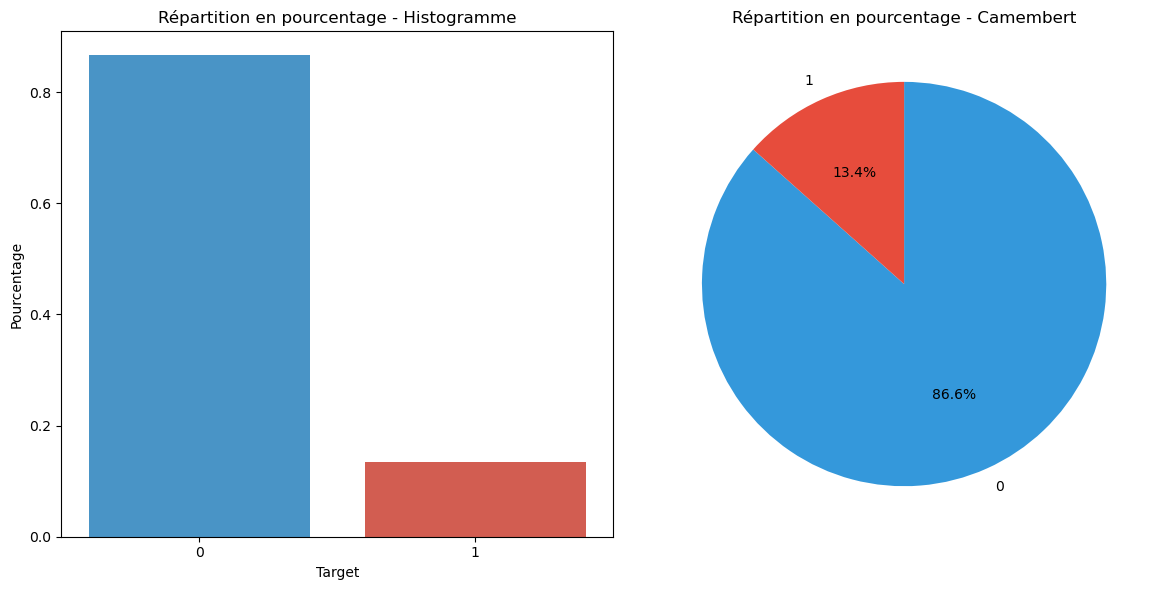

In [6]:
# Compter les occurrences des valeurs dans df['target']
target_counts = df['target'].value_counts(normalize=True)

# Créer une figure avec deux sous-graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogramme à gauche
sns.barplot(x=target_counts.index, y=target_counts.values, 
            hue=target_counts.index, palette=["#3498db", "#e74c3c"], dodge=False, legend=False, ax=axes[0])
axes[0].set_xlabel('Target')
axes[0].set_ylabel('Pourcentage')
axes[0].set_title('Répartition en pourcentage - Histogramme')

# Camembert à droite
axes[1].pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%', 
            colors=["#3498db", "#e74c3c"], startangle=90, counterclock=False)
axes[1].set_title('Répartition en pourcentage - Camembert')

plt.tight_layout()
plt.show()

## 2) Extraction des *word embeddings* via Word2Vec

Quelques sources...

* https://radimrehurek.com/gensim/models/word2vec.html
* https://datascientest.com/nlp-word-embedding-word2vec

In [7]:
from gensim.models import Word2Vec

In [8]:
def tokenize(text):
    """
    Tokenize le texte en une liste de mots.
    """
    return text.lower().split()

In [9]:
def extract_word_embd(df, vec_size=100):
    """
    Cette méthode prend en entrée un DataFrame 'df', entraîne un modèle Word2Vec,
    et retourne 'df' avec une nouvelle colonne contenant un dictionnaire des tokens et leurs word embeddings.
    
    `vec_size`: dimension du vecteur. Plus vec_size est élevé, plus on peut capter de sémentique distinctes. 
    Attention à ne pas travailler avec de trop grandes dimensions...
    """
    # Tokeniser les textes dans la colonne 'text'
    df['tokenized_text'] = df['text'].apply(tokenize)

    # Entraîner le modèle Word2Vec sur les textes tokenisés
    model = Word2Vec(sentences=df['tokenized_text'], vector_size=vec_size, window=5, min_count=1, workers=4,seed=177)

    # Obtenir un dictionnaire des tokens et de leurs embeddings pour chaque texte
    def get_word_embedding_dict(tokenized_text):
        word_embedding_dict = {word: model.wv[word] for word in tokenized_text if word in model.wv}
        return word_embedding_dict
        
    # Calculer les word embeddings pour chaque texte
    word_embeddings_list = []
    for tokenized_text in tqdm(df['tokenized_text'], desc='calcul de word embedding...'):
        word_embedding = get_word_embedding_dict(tokenized_text)
        word_embeddings_list.append(word_embedding)
    
    # Ajouter la liste des word embeddings en tant que nouvelle colonne dans le DataFrame
    df['word_embeddings'] = word_embeddings_list
    
    # df['word_embeddings'] = df['tokenized_text'].apply(get_word_embedding_dict)
    
    # Associer la longueur du dictionnaire d'embeddings à chaque observation
    df['len_dico'] = df['word_embeddings'].apply(lambda d: len(d))

    # Supprimer la colonne 'tokenized_text' maintenant inutile
    df = df.drop(columns=['tokenized_text'])
    
    return df

In [10]:
# Obtention des word embeddings
df_we = extract_word_embd(df)

calcul de word embedding...: 100%|███████| 5572/5572 [00:00<00:00, 56642.28it/s]


In [11]:
df_we.head()

,text,target,word_embeddings,len_dico
0,"Go until jurong point, crazy.. Available only ...",0,"{'go': [-0.34138602, 0.18105742, 1.035313, 1.0...",20
1,Ok lar... Joking wif u oni...,0,"{'ok': [-0.20060277, 0.12750539, 0.6013699, 0....",6
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,"{'free': [-0.344245, 0.1807126, 0.9684378, 1.0...",24
3,U dun say so early hor... U c already then say...,0,"{'u': [-0.41555744, 0.21242239, 1.2778972, 1.2...",10
4,"Nah I don't think he goes to usf, he lives aro...",0,"{'nah': [-0.009405118, 0.0014766935, 0.0481459...",12


### Prendre des exemples simples et comparer leur similarité

In [12]:
vec_size = 100
model = Word2Vec(sentences=df['tokenized_text'], vector_size=vec_size, window=5, min_count=1, workers=4,seed=177)

mot1 = "cat"
vec1 = model.wv[mot1]

mot2 = "dog"
vec2 = model.wv[mot2]

mot3 = "building"
vec3 = model.wv[mot3]

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

# On s'assure que les vecteurs soient bien au format matrices 2D (1 ligne et vec_size colonnes)
vec1_2d = vec1.reshape(1, -1)
vec2_2d = vec2.reshape(1, -1)
vec3_2d = vec3.reshape(1, -1)

# Calcul de la similarité cosinus
dist_1_2 = cosine_similarity(vec1_2d, vec2_2d)
dist_1_3 = cosine_similarity(vec1_2d, vec3_2d)
dist_2_3 = cosine_similarity(vec2_2d, vec3_2d)

print(f"La cosinus similarité entre '{mot1}' et '{mot2}' vaut {dist_1_2[0][0]:.4f}, soit {dist_1_2[0][0]*100:.2f}%.")
print(f"La cosinus similarité entre '{mot1}' et '{mot3}' vaut {dist_1_3[0][0]:.4f}, soit {dist_1_3[0][0]*100:.2f}%.")
print(f"La cosinus similarité entre '{mot2}' et '{mot3}' vaut {dist_2_3[0][0]:.4f}, soit {dist_2_3[0][0]*100:.2f}%.")

La cosinus similarité entre 'cat' et 'dog' vaut 0.9552, soit 95.52%.
La cosinus similarité entre 'cat' et 'building' vaut 0.9374, soit 93.74%.
La cosinus similarité entre 'dog' et 'building' vaut 0.9477, soit 94.77%.


## 3) Calcul du sentence embedding via Arora

In [19]:
from sklearn.decomposition import TruncatedSVD

In [20]:
import warnings

# Désactiver spécifiquement le RuntimeWarning lié aux "invalid value encountered in divide"
warnings.filterwarnings("ignore", message="invalid value encountered in divide", category=RuntimeWarning)

# Classe pour définir les paramètres
class Params:
    def __init__(self, rmpc):
        self.rmpc = rmpc

def get_weighted_average(We, x, w):
    """
    Compute the weighted average vectors
    :param We: We[i,:] is the vector for word i
    :param x: x[i, :] are the indices of the words in sentence i
    :param w: w[i, :] are the weights for the words in sentence i
    :return: emb[i, :] are the weighted average vector for sentence i
    """
    n_samples = x.shape[0]
    emb = np.zeros((n_samples, We.shape[1]))
    for i in range(n_samples):
        emb[i,:] = w[i,:].dot(We[x[i,:],:]) / np.count_nonzero(w[i,:])
    return emb

def compute_pc(X, npc=1):
    """
    Compute the principal components. DO NOT MAKE THE DATA ZERO MEAN!
    :param X: X[i,:] is a data point
    :param npc: number of principal components to remove
    :return: component_[i,:] is the i-th pc
    """
    # Remplacer les NaN et valeurs infinies par 0
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Vérification supplémentaire pour s'assurer que la matrice est correctement nettoyée
    if np.any(np.isnan(X)) or np.any(np.isinf(X)):
        print("Attention : La matrice contient encore des valeurs non numériques après nettoyage.")

    # Appliquer TruncatedSVD
    svd = TruncatedSVD(n_components=npc, n_iter=7, random_state=0)
    svd.fit(X)
    return svd.components_

def remove_pc(X, npc=1):
    """
    Remove the projection on the principal components
    :param X: X[i,:] is a data point
    :param npc: number of principal components to remove
    :return: XX[i, :] is the data point after removing its projection
    """
    pc = compute_pc(X, npc)
    if npc==1:
        XX = X - X.dot(pc.transpose()) * pc
    else:
        XX = X - X.dot(pc.transpose()).dot(pc)
    return XX


def SIF_embedding(We, x, w, params):
    """
    Compute the scores between pairs of sentences using weighted average + removing the projection on the first principal component
    :param We: We[i,:] is the vector for word i
    :param x: x[i, :] are the indices of the words in the i-th sentence
    :param w: w[i, :] are the weights for the words in the i-th sentence
    :param params.rmpc: if >0, remove the projections of the sentence embeddings to their first principal component
    :return: emb, emb[i, :] is the embedding for sentence i
    """
    emb = get_weighted_average(We, x, w)
    if  params.rmpc > 0:
        emb = remove_pc(emb, npc = params.rmpc)
    return emb

In [21]:
# Fonction pour calculer les poids SIF
def compute_sif_weights(word_occurence, total_words, a=1e-3):
    """
    Calcule les poids SIF pour chaque mot
    :param word_occurence: dictionnaire de fréquence des mots (en nbr d'occurrence)
    :param total_words: nombre total de mots dans le corpus
    :param a: paramètre de lissage
    :return: dictionnaire de poids pour chaque mot
    """
    sif_weights = {word: a / (a + (freq / total_words)) for word, freq in word_occurence.items()}
    return sif_weights


# Fonction principale pour traiter chaque rapport indépendamment
def process_report(word_embeddings, a_arora=1e-3):
    all_words = []
    all_embeddings = []
    word_occurence = {}

    # Collecter les embeddings et calculer la fréquence des mots pour le rapport actuel
    for word, embedding in word_embeddings.items():
        all_words.append(word)
        all_embeddings.append(embedding)
        word_occurence[word] = word_occurence.get(word, 0) + 1

    # Convertir les embeddings en matrice numpy
    We = np.vstack(all_embeddings)

    # Calculer les poids SIF pour le rapport actuel
    total_words = len(all_words)
    sif_weights = compute_sif_weights(word_occurence, total_words, a= a_arora)

    # Créer x et w pour le rapport actuel
    x = np.array([[i for i, _ in enumerate(all_words)]])
    w = np.array([[sif_weights[word] for word in all_words]])

    return We, x, w


def arora_methods(
    df,
    var_text="text",
    remove_pc_nbr = 1,
    a_arora=1e-3
):
    """
    Calcule les embeddings de phrases pour un DataFrame en utilisant la méthode Arora.

    Args:
        df (pd.DataFrame): DataFrame contenant les données.
        var_text (str): Nom de la colonne contenant les textes (par défaut "text").
        a_arora (float): Paramètre de lissage SIF (par défaut 1e-3).

    Returns:
        pd.DataFrame: DataFrame avec une colonne 'embeddings' ajoutée.
    """
    params = Params(rmpc=remove_pc_nbr)

    # Initialiser une liste pour stocker les embeddings des phrases
    sentence_embeddings_list = []

    # Boucle avec tqdm pour afficher la progression
    for we in tqdm(df['word_embeddings'], desc="Calcul des sentence embeddings..."):
        # Appliquer process_report et SIF_embedding sur chaque ensemble d'embeddings de mots
        We, x, w = process_report(we, a_arora=a_arora)
        sentence_embedding = SIF_embedding(We, x, w, params)
        # Ajouter l'embedding calculé à la liste
        sentence_embeddings_list.append(sentence_embedding)

    # Ajouter les embeddings calculés au DataFrame
    sentence_embeddings_list = [np.squeeze(embedding) for embedding in sentence_embeddings_list]
    df['sentence_embeddings'] = sentence_embeddings_list

    return df

In [22]:
df_arora = arora_methods(df_we, remove_pc_nbr = 0)

Calcul des sentence embeddings...: 100%|█| 5572/5572 [00:00<00:00, 25748.26it/s]


In [23]:
df_arora.head()

,text,target,word_embeddings,len_dico,sentence_embeddings
0,"Go until jurong point, crazy.. Available only ...",0,"{'go': [-0.34138602, 0.18105742, 1.035313, 1.0...",20,"[-0.002584329832590062, 0.0015815068629237035,..."
1,Ok lar... Joking wif u oni...,0,"{'ok': [-0.20060277, 0.12750539, 0.6013699, 0....",6,"[-0.0007736532648962369, 0.0004264258567353055..."
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,"{'free': [-0.344245, 0.1807126, 0.9684378, 1.0...",24,"[-0.003419838959871413, 0.0019497634746699077,..."
3,U dun say so early hor... U c already then say...,0,"{'u': [-0.41555744, 0.21242239, 1.2778972, 1.2...",10,"[-0.00181316343864592, 0.0010050356220961134, ..."
4,"Nah I don't think he goes to usf, he lives aro...",0,"{'nah': [-0.009405118, 0.0014766935, 0.0481459...",12,"[-0.0019112110092845776, 0.0011467085201053956..."


## 4) Apprentissage d'un modèle pour classification

ÉNONCÉ : 

1. À partir de sentence embedings calculé par méthode d'Arora, construire un modèle qui prédit si le texte est à classer comme SPAM ou non.
* Pour cela, il faut **split** le dataset en train/test. (Quelle est ma variable explicative ? Quelle est ma variable cible ?)
* On importe le modèle (RandomForest, Régression Logistique ou autre...) pour faire de la **classification**. On l'instance, et on l'entraine avec les données d'entraînement.
* On **quantifie** la **qualité** du modèle en comparant les prédictions des tests avec les valeurs réelles. (*Quels scores peut-on utiliser pour cela ?*)

2. Suppsons qu'on dispose d'un modèle `rf_model` dont les scores sont jugés suffisement bons. Que donne-t-il appliqué à un dataset exterieur ?

In [34]:
# Création d'un dataframe artificiel
data = {'text': ['what about', 'see the last new of our model', 'win last phone', 
                 'WINNER!! As a valued network customer you have been selected to receive a price']}
df_newdata = pd.DataFrame(data)
df_newdata = extract_word_embd(df_newdata)
df_newdata = arora_methods(df_newdata, remove_pc_nbr = 0)
X_new = np.stack(df_newdata['sentence_embeddings'].values)
rf_model.predict(X_new)

Calcul des sentence embeddings...: 100%|████████| 4/4 [00:00<00:00, 5480.96it/s]


array([0, 0, 0, 1])

In [35]:
df_newdata

,text,word_embeddings,len_dico,sentence_embeddings
0,what about,"{'what': [0.0062725055, -0.004816598, 0.005779...",2,"[6.55528786731605e-06, -1.2350935552142812e-05..."
1,see the last new of our model,"{'see': [0.004178965, -0.0081762215, -0.008330...",7,"[5.650625965542271e-06, -2.3830496722715772e-0..."
2,win last phone,"{'win': [-0.0060812817, 0.0022920144, -0.00748...",3,"[-8.174083135271833e-06, -3.6344584042776527e-..."
3,WINNER!! As a valued network customer you have...,"{'winner!!': [-0.007505118, 0.0071286694, -0.0...",13,"[-2.602509491036206e-05, 1.4882500941114938e-0..."
